In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [29]:
SONNETS_FILE = './sonnets.txt'

with open('./sonnets.txt') as f:
    data = f.read()

corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2140 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,5


In [30]:
#removing numbers that got into the text when copying
for j in range(len(corpus)):
    corpus[j] = ''.join([i for i in corpus[j] if not i.isdigit()])

In [31]:
for i in range(5):
  print(corpus[i])

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


In [32]:
#tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [33]:
corpus[0]

'from fairest creatures we desire increase,'

In [34]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 416, 868, 164, 215, 513]]

In [35]:
#generating n_grams sequence
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
      sequence = tokenizer.texts_to_sequences([line])[0]

      for i in range(1, len(sequence)):
        n_grid = sequence[:i+1]
        input_sequences.append(n_grid)

    return input_sequences

In [36]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 416],
 [34, 416, 868],
 [34, 416, 868, 164],
 [34, 416, 868, 164, 215],
 [34, 416, 868, 164, 215, 513]]

In [37]:
# applying the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15353
maximum length of sequences is: 11


In [38]:
#adding pre-padding to the sequences
def pad_seqs(input_sequences, maxlen):
    
    padded_sequences = pad_sequences(input_sequences, maxlen = maxlen)
    return padded_sequences

In [39]:
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 416],
       [  0,   0,   0,  34, 416, 868],
       [  0,   0,  34, 416, 868, 164],
       [  0,  34, 416, 868, 164, 215],
       [ 34, 416, 868, 164, 215, 513]])

In [40]:
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15353, 11)


In [41]:
#spliting the data where labels are the last words of the sequences
def features_and_labels(input_sequences, total_words):
    
    features = input_sequences[:, :-1]
    labels = input_sequences[:, -1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [42]:
features, labels = features_and_labels(input_sequences, total_words)

## Model

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.84):
      print("\nReached 84% accuracy")
      self.model.stop_training = True

In [17]:
def create_model(total_words, max_sequence_len):
    
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len -1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

In [20]:
model = create_model(total_words, max_sequence_len)

# Train the model
callbacks = myCallback()
history = model.fit(features, labels, callbacks=callbacks, epochs=50, verbose=1)

Epoch 1/50
480/480 [==============================] - 17s 26ms/step - loss: 6.8717 - accuracy: 0.0234
Epoch 2/50
480/480 [==============================] - 13s 27ms/step - loss: 6.4112 - accuracy: 0.0338
Epoch 3/50
480/480 [==============================] - 13s 27ms/step - loss: 6.1604 - accuracy: 0.0413
Epoch 4/50
480/480 [==============================] - 15s 32ms/step - loss: 5.8957 - accuracy: 0.0533
Epoch 5/50
480/480 [==============================] - 15s 31ms/step - loss: 5.5857 - accuracy: 0.0640
Epoch 6/50
480/480 [==============================] - 15s 31ms/step - loss: 5.2384 - accuracy: 0.0757
Epoch 7/50
480/480 [==============================] - 15s 32ms/step - loss: 4.8492 - accuracy: 0.0967
Epoch 8/50
480/480 [==============================] - 16s 34ms/step - loss: 4.4368 - accuracy: 0.1267
Epoch 9/50
480/480 [==============================] - 16s 33ms/step - loss: 4.0066 - accuracy: 0.1828
Epoch 10/50
480/480 [==============================] - 14s 30ms/step - loss: 3.600

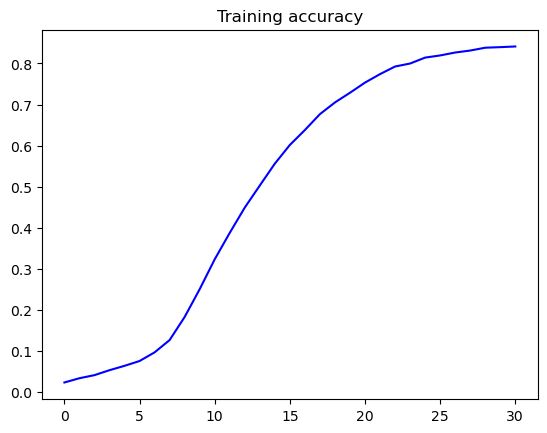

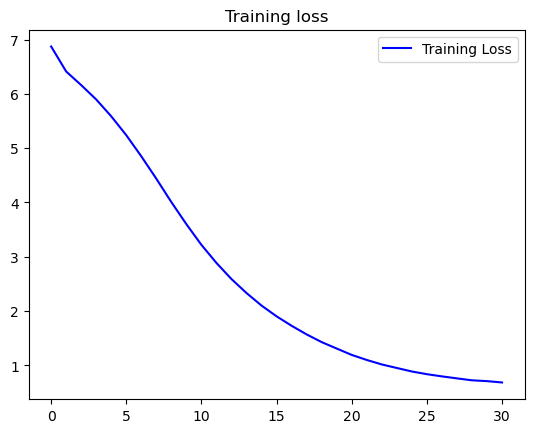

In [21]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [43]:
#trying it out on an example
seed_text = "One day I wrote her name upon the "
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted, axis=-1).item()
    output_word = tokenizer.index_word[predicted]
    seed_text += " " + output_word

print(seed_text)

One day I wrote her name upon the  spring and night of brow pride lie so cross you
